In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import Lasso

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 0) Load Dataset

In [ ]:
# Load train and test data
train_df = pd.read_csv("../../data/train_data.csv")
test_df = pd.read_csv("../../data/test_data.csv")

In [5]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

In [7]:
X_train.dtypes

gender                             object
state                              object
zip                                 int64
city_pop                            int64
job                                object
category                           object
amt                               float64
hour                                int64
day_of_week                        object
month                              object
trans_quarter                      object
year                                int64
age                                 int64
prev_trans_fraud                    int64
count_fraud_7days                   int64
acc_fraud_count                     int64
merchant_prev_trans_fraud           int64
merchant_count_fraud_past7days      int64
merchant_acc_fraud_count            int64
transaction_risk_score              int64
hourly_risk_score                   int64
visited_cat                         int64
city_population_class               int64
interval                          

In [13]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Resampling
# Step 1: Undersample
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
x_under, y_under = undersampler.fit_resample(X_train, y_train)

# Step 2: Oversample with SMOTENC
smotenc = SMOTENC(categorical_features=categorical_columns_idx, 
                  random_state=123, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smotenc.fit_resample(x_under, y_under)

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_f

# 1) GridSearchCV + Group Lasso

In [99]:
# Preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Pipeline for each fold
pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('model', xgb.XGBClassifier(use_label_encoder=False, random_state = 123))
])

# Define the hyperparameter grid
param_grid = {
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.5, 0.8],
    'model__scale_pos_weight': [1],
    'model__eta':[0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:09:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         Index(['gender', 'state', 'job', 'category', 'day_of_week', 'month',
       'trans_quarter'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['zip', 'city_pop', 'amt', 'hour', 'year', 'age', '...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=123, ...))]),
             param_grid={'model__eta': [0.1], 'model__learning_rate': [0.1],
                         'model__max_depth': [3, 5, 8],
                         'model__scale_pos_weight': [1],
                         'model__subsample': [0.3, 0.5, 0.8]},
             scoring='f1')

## Evaluating model performance

In [100]:
# Print the best set of hyperparameters
print("Best set of hyperparameters: ", grid_search.best_params_)

# Get best model and test performance
best_model = grid_search.best_estimator_

Best set of hyperparameters:  {'model__eta': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__scale_pos_weight': 1, 'model__subsample': 0.5}


In [101]:
# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_model, X_train_resampled, y_train_resampled, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_resampled, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_resampled, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_resampled, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_resampled, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_resampled, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 4)}')

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:11:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [11:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm


Lasso Pipeline Results:
accuracy: 0.9980811403508771, precision: 0.9979025036626414, recall: 0.9977796052631579, f1: 0.9978410165070555
AUC: 0.9978


### Confusion matrix

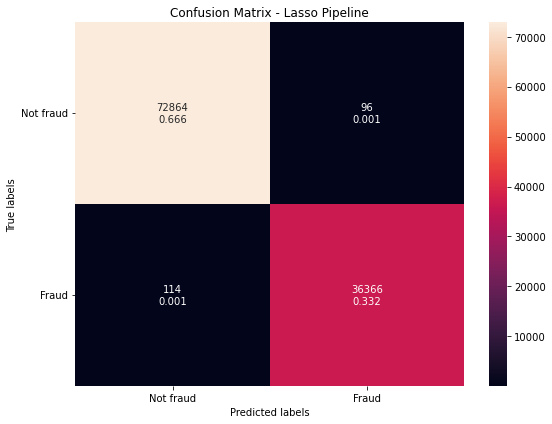

In [102]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_resampled, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

## Selected features

Selected features:
1. cat__category_grocery_net
2. cat__category_grocery_pos
3. cat__category_misc_net
4. cat__category_shopping_net
5. cat__trans_quarter_2021Q2
6. cat__trans_quarter_2022Q1
7. num__amt
8. num__hour
9. num__year
10. num__prev_trans_fraud
11. num__count_fraud_7days
12. num__acc_fraud_count
13. num__merchant_prev_trans_fraud
14. num__merchant_count_fraud_past7days
15. num__merchant_acc_fraud_count
16. num__transaction_risk_score
17. num__hourly_risk_score
18. num__visited_cat
19. num__city_population_class
20. num__interval
21. num__first_second_purchase
22. num__influential_merchant

Total selected features: 22

Top 10 most important features:
                      Feature  Importance
17                visited_cat    0.891064
9            prev_trans_fraud    0.078730
12  merchant_prev_trans_fraud    0.004877
11            acc_fraud_count    0.003404
16          hourly_risk_score    0.002725
6                         amt    0.002514
10          count_fraud_7days    0.002

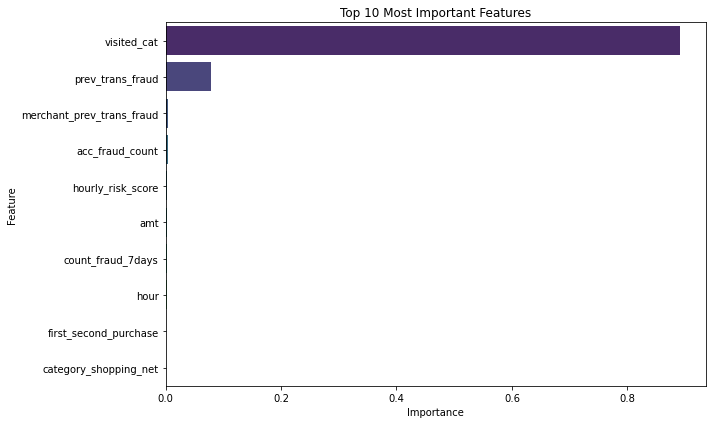

In [113]:
# access Lasso step from pipeline
selector=best_model.named_steps['feature_selection']

feature_names= best_model.named_steps['preprocessor'].get_feature_names_out()
selected_features=feature_names[selector.get_support()]

# Print total count
print(f"\nTotal selected features: {len(selected_features)}")

# Print selected features 
print("Selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")


# Get feature importances from the classifier
feature_importances = best_model.named_steps['model'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': [x[5:] for x in selected_features],
    'Importance': feature_importances
})

top10_df = importance_df.sort_values(by='Importance', ascending=False)[:10]

print('\nTop 10 most important features:')
print(top10_df)

# Graph of Features according to their importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 2) RFECV

## Training model

In [1]:
rfecv = RFECV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc'),
    step=0.1,
    min_features_to_select = 5,
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Pipeline for each fold
rfecv_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv),
    ('model', xgb.XGBClassifier(use_label_encoder=False, random_state = 123))
])

# Preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Define the hyperparameter grid
param_grid = {
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.5, 0.8],
    'model__scale_pos_weight': [1],
    'model__eta':[0.1]
}

# Create the GridSearchCV object
rfecv_grid_search = GridSearchCV(rfecv_pipeline, param_grid, cv=5, scoring='f1', error_score='raise')

# Fit the GridSearchCV object to the training data
rfecv_grid_search.fit(X_train_resampled, y_train_resampled)


### Evaluate model performance

In [125]:
# Print the best set of hyperparameters
print("Best set of hyperparameters: ", rfecv_grid_search.best_params_)

# Get best model and test performance
rfecv_best_model = rfecv_grid_search.best_estimator_

Best set of hyperparameters:  {'model__eta': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__scale_pos_weight': 1, 'model__subsample': 0.8}


In [126]:
# Evaluate using cross-validation
sk_folds_rfecv = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_rfecv_pipe = cross_val_predict(rfecv_best_model, X_train_resampled, y_train_resampled, cv=sk_folds_rfecv)

# Calculate metrics
auc_rfecv_pipe = roc_auc_score(y_train_resampled, y_pred_rfecv_pipe)
print("\nRFECV Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_resampled, y_pred_rfecv_pipe)}, "
      f"precision: {precision_score(y_train_resampled, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_resampled, y_pred_rfecv_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_resampled, y_pred_rfecv_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_rfecv_pipe, 4)}')

Fitting estimator with 548 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 494 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 440 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 386 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 332 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 278 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 224 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 170 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:55:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

Fitting estimator with 548 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 494 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 440 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 386 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 332 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 278 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 224 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 170 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

Fitting estimator with 548 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 494 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 440 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 386 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 332 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 278 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 224 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 170 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

Fitting estimator with 548 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 494 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 440 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 386 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 332 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 278 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 224 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 170 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 116 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

Fitting estimator with 548 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 494 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 440 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 386 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 332 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 278 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 224 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 170 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 116 features.


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm


RFECV Pipeline Results:
accuracy: 0.9982730263157895, precision: 0.998115020579651, recall: 0.997998903508772, f1: 0.9980569281803893
AUC: 0.998


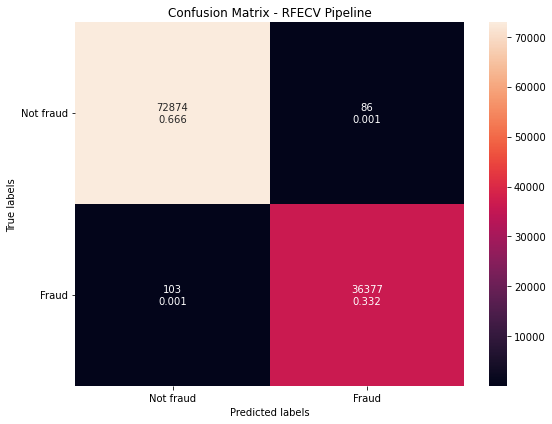

In [133]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_rfecv = confusion_matrix(y_train_resampled, y_pred_rfecv_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_rfecv.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_rfecv)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for RFECV Pipeline
ax = plt.subplot()
sns.heatmap(cm_rfecv, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - RFECV Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()


Total selected features: 116

Top 10 most important features:
                       Feature  Importance
110                visited_cat    0.875651
102           prev_trans_fraud    0.073432
105  merchant_prev_trans_fraud    0.003970
104            acc_fraud_count    0.002958
98                         amt    0.002815
109          hourly_risk_score    0.002653
99                        hour    0.001968
103          count_fraud_7days    0.001615
71            month_2021-05-01    0.001183
112                   interval    0.000938


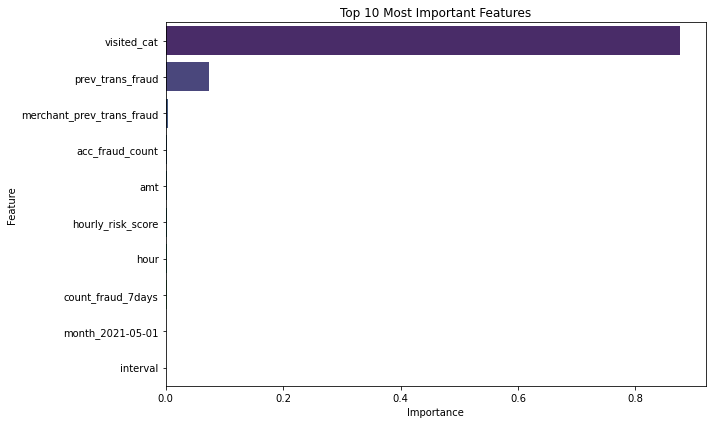

In [128]:
# access RFECV step from pipeline
selector=rfecv_best_model.named_steps['feature_selection']

feature_names= rfecv_best_model.named_steps['preprocessor'].get_feature_names_out()
selected_features=feature_names[selector.get_support()]

# Print total count
print(f"\nTotal selected features: {len(selected_features)}")

# Get feature importances from the classifier
feature_importances = rfecv_best_model.named_steps['model'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': [x[5:] for x in selected_features],
    'Importance': feature_importances
})

top10_df = importance_df.sort_values(by='Importance', ascending=False)[:10]

print('\nTop 10 most important features:')
print(top10_df)

# Graph of Features according to their importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()